In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_data(n):
    A = np.ones((n,n))
    for i in range(1,n+1):
        for j in range(1,n+1):
            A[i-1,j-1] /= i+j-1
    x_ = np.ones((n,1))
    b = np.dot(A, x_)
    return A, b

# Часть 1

## Задание 1 (обратная матрица)

In [3]:
ms = [2, 4, 6, 8, 16, 32, 64]
errs = []
for m in ms:
    A_m, b_m = generate_data(m)
    x_m = np.ones((m,1))
    A_m_inv = np.linalg.inv(A_m)
    x_m_sol = A_m_inv @ b_m
    errs.append(np.linalg.norm(b_m - A_m@x_m_sol))

Text(0.5, 0, '$m$')

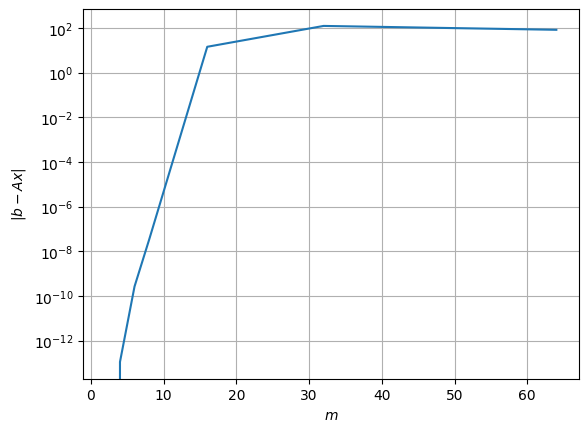

In [4]:
plt.plot(ms,errs)
plt.yscale("log")
plt.grid()
plt.ylabel("$|b-Ax|$")
plt.xlabel("$m$")

## Задание 2 (градиеетный спуск)

Задача: $\hat{x}=argmin(|b-Ax| ^2)$ $-$ используем минимизацию выпуклой функции для градиентных методов

$|b-Ax|^2 = (b-Ax)(b^T-x^TA^T)$

Воспользуемся методом градиентного спуска:

$x_{k+1}=x_k - \gamma\nabla f(x_k)$

In [5]:
def calculate_grad(f,h,x):
    df_dx_i = []
    for x_i in range(x.shape[0]):
        h_vec = np.zeros(x.shape)
        h_vec[x_i,0] = h
        df_dx_i.append((f(x + h_vec) - f (x))/h)
    return np.array(df_dx_i)

In [6]:
def gradient_des(f,h,x_0,eps,gamma):
    x_next = [x_0]
    f_values = [f(x_0)]
    while f_values[-1] >= eps:
        x_next.append(x_next[-1] - gamma * calculate_grad(f,h,x_next[-1]).reshape((m,1)))
        f_values.append(f(x_next[-1]))
    return x_next, f_values

Выберем $\gamma=0.2$, желаемая точность квадрата ошибки: $\varepsilon=0.001$

In [9]:
errs = dict()
iters = []
for m in ms:
    A_m, b_m = generate_data(m)
    x_m = np.ones((m,1))
    f = lambda x: ((b_m.T - x.T@A_m.T)@(b_m - A_m@x))[0,0]
    x_m_sol, func = gradient_des(f,10**-5,np.zeros((m,1)),10**-3,0.2)
    iters.append(len(x_m_sol))
    errs[m] = (x_m_sol, func)

Построим график количества необходимых итерацих в зависимости от размерности матрицы:

Text(0, 0.5, 'Iterations')

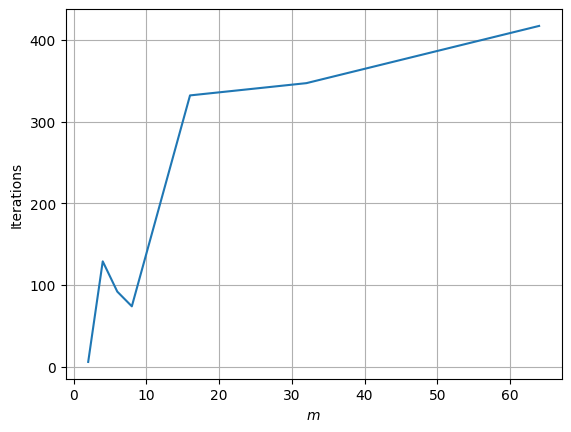

In [14]:
plt.plot(ms, iters)
plt.grid()
plt.xlabel("$m$")
plt.ylabel("Iterations")

Посторим график значений минимизируемой функции для каждой размерности:

Text(0.5, 0, 'Iterations')

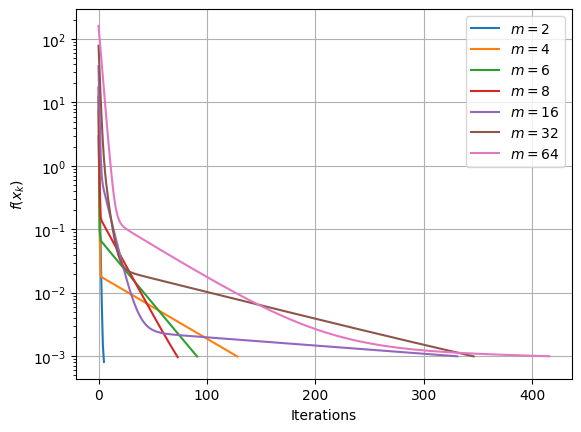

In [22]:
for m in ms:
    plt.plot(errs[m][1],label="$m="+str(m)+"$")
plt.yscale("log")
plt.legend()
plt.grid()
plt.ylabel("$f(x_k)$")
plt.xlabel("Iterations")

Постороим график ошибки решения для каждой размерности:

Text(0.5, 0, 'Iterations')

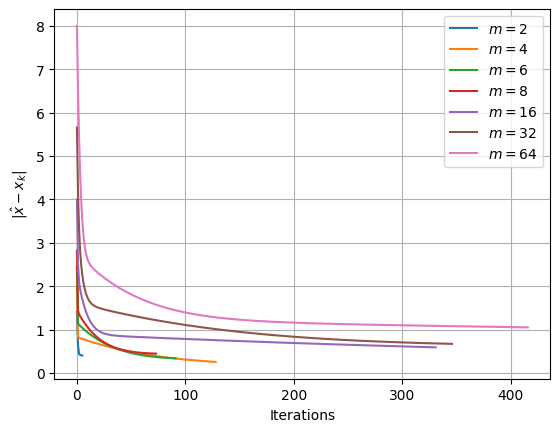

In [26]:
for m in ms:
    plt.plot(np.linalg.norm(errs[m][0]-np.ones((m,1)),axis=1),label="$m="+str(m)+"$")
# plt.yscale("log")
plt.legend()
plt.grid()
plt.ylabel("$|\hat{x}-x_k|$")
plt.xlabel("Iterations")

## Задание 3 (сопряженные градиенты)

In [53]:
def Hestens_Shtiefel(A, b, x_0):
    g = A@x_0 - b
    xs = [x_0.copy()]
    if np.allclose(g, np.zeros_like(x_0)):
        return xs
    d = -g
    x = x_0
    while not np.allclose(g, np.zeros_like(x_0)):
        alpha = np.inner(g[:,0],g[:,0]) / np.inner((A@d)[:,0], d[:,0])
        # print(d)
        x += alpha * d
        xs.append(x.copy())
        g_last = g.copy()
        g += alpha*A@d
        if np.allclose(g, np.zeros_like(x_0)):
            return xs
        beta = np.linalg.norm(g)**2 / np.linalg.norm(g_last)**2
        d = -g + beta * d
    return xs

In [54]:
errs = dict()
iters = []
for m in ms:
    A_m, b_m = generate_data(m)
    x_m = np.ones((m,1))
    f = lambda x: ((b_m.T - x.T@A_m.T)@(b_m - A_m@x))[0,0]
    x_m_sol = Hestens_Shtiefel(A_m, b_m, np.zeros((m,1)))
    iters.append(len(x_m_sol))
    errs[m] = x_m_sol

Построим график количества необходимых итерацих в зависимости от размерности матрицы:

Text(0, 0.5, 'Iterations')

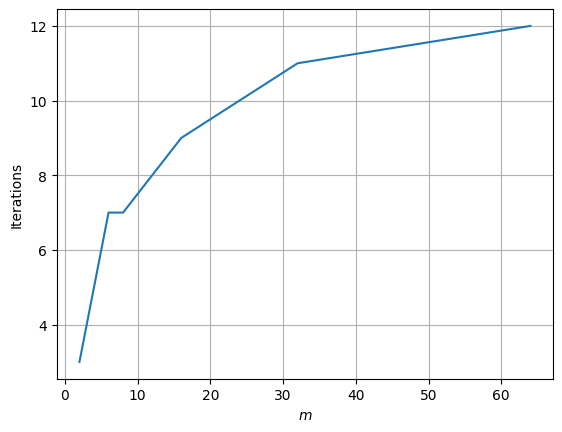

In [57]:
plt.plot(ms, iters)
plt.grid()
plt.xlabel("$m$")
plt.ylabel("Iterations")

Постороим график ошибки решения для каждой размерности:

Text(0.5, 0, 'Iterations')

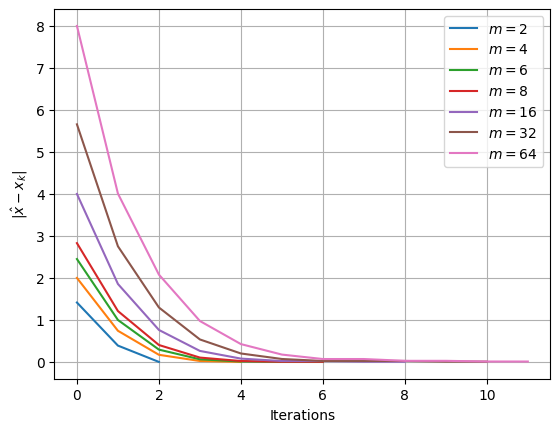

In [56]:
for m in ms:
    plt.plot(np.linalg.norm(errs[m]-np.ones((m,1)),axis=1),label="$m="+str(m)+"$")
# plt.yscale("log")
plt.legend()
plt.grid()
plt.ylabel("$|\hat{x}-x_k|$")
plt.xlabel("Iterations")

# Часть 2

## Задание 1 и 2 (метод Флетчера-Ривса)

In [66]:
import scipy.optimize


def minimize_alpha(A, b, x_0, s):
    f = lambda alpha : np.linalg.norm(A@(x_0 + alpha*s) - b)**2
    return scipy.optimize.minimize(f, 0).x[0]

In [72]:
def Fletcher_Rieves(A, b, x_0):
    delta_x = -2 * A.T @ (A@x_0 - b)
    s = delta_x.copy()
    alpha = minimize_alpha(A,b,x_0,s)
    
    x = x_0 + alpha * delta_x
    xs = [x_0, x.copy()]
    for _ in range(x_0.shape[0]):
        last_delta_x = delta_x.copy()
        delta_x = -2 * A.T @ (A@x - b)
        beta = np.linalg.norm(delta_x)**2 / np.linalg.norm(last_delta_x)**2
        s = delta_x + beta * s
        alpha = minimize_alpha(A,b,x,s)
        if np.allclose(alpha*s, np.zeros_like(x_0)):
            return xs
        x += alpha*s
        xs.append(x.copy())
    return xs

In [73]:
errs = dict()
iters = []
for m in ms:
    A_m, b_m = generate_data(m)
    x_m = np.ones((m,1))
    f = lambda x: ((b_m.T - x.T@A_m.T)@(b_m - A_m@x))[0,0]
    x_m_sol = Fletcher_Rieves(A_m, b_m, np.zeros((m,1)))
    iters.append(len(x_m_sol))
    errs[m] = x_m_sol

Text(0.5, 0, 'Iterations')

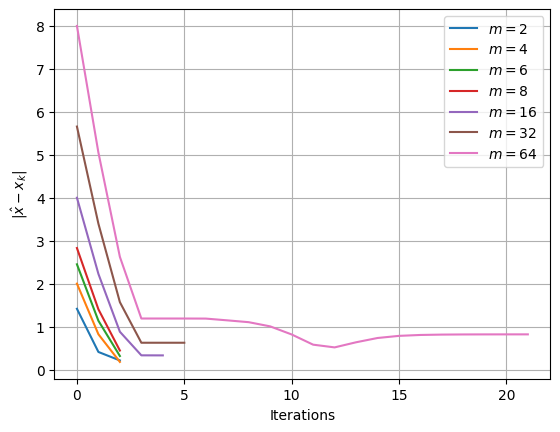

In [74]:
for m in ms:
    plt.plot(np.linalg.norm(errs[m]-np.ones((m,1)),axis=1),label="$m="+str(m)+"$")
# plt.yscale("log")
plt.legend()
plt.grid()
plt.ylabel("$|\hat{x}-x_k|$")
plt.xlabel("Iterations")

## Задание 3

Для отрицательно определенной матрицы:

In [75]:
Fletcher_Rieves(-A_m,b_m,np.zeros((m,1)))[-1]

array([[-0.78452416],
       [-1.49612327],
       [-1.24447679],
       [-1.03859161],
       [-0.91578373],
       [-0.85073583],
       [-0.82183208],
       [-0.81491094],
       [-0.82109397],
       [-0.834836  ],
       [-0.85265766],
       [-0.87236751],
       [-0.89258687],
       [-0.91245638],
       [-0.93145202],
       [-0.94926796],
       [-0.9657409 ],
       [-0.98080058],
       [-0.99443707],
       [-1.00667894],
       [-1.01757868],
       [-1.0272029 ],
       [-1.03562572],
       [-1.04292434],
       [-1.04917619],
       [-1.05445699],
       [-1.0588396 ],
       [-1.06239327],
       [-1.0651833 ],
       [-1.06727086],
       [-1.06871298],
       [-1.0695627 ],
       [-1.06986914],
       [-1.06967777],
       [-1.06903057],
       [-1.06796628],
       [-1.06652062],
       [-1.06472651],
       [-1.06261426],
       [-1.06021177],
       [-1.05754477],
       [-1.05463691],
       [-1.05150998],
       [-1.04818404],
       [-1.04467758],
       [-1

Для случайной матрицы:

In [81]:
A_m = np.random.random((m,m))
b_m = A_m @ np.ones((m,1))
np.linalg.norm(np.ones((m,1))-Fletcher_Rieves(A_m, b_m, np.zeros((m,1)))[-1])

0.1022686709056562

In [82]:
Fletcher_Rieves(A_m, b_m, np.zeros((m,1)))[-1]

array([[0.98567771],
       [0.99184632],
       [0.9944633 ],
       [0.99145022],
       [0.9824285 ],
       [0.99467596],
       [0.9931215 ],
       [0.99741514],
       [1.00391328],
       [1.01861697],
       [1.02167059],
       [0.99464455],
       [0.99435552],
       [0.99604075],
       [1.02075888],
       [1.02134166],
       [1.01481977],
       [1.00952769],
       [0.99471298],
       [0.98863195],
       [1.00608229],
       [0.99528673],
       [1.00309595],
       [0.9992927 ],
       [1.00580045],
       [1.00150716],
       [1.00456447],
       [1.01154693],
       [1.02121937],
       [1.01237453],
       [1.00349697],
       [0.98222883],
       [0.98185306],
       [0.98667162],
       [0.99048182],
       [0.9774807 ],
       [1.01156068],
       [0.98205751],
       [0.98349495],
       [0.99607669],
       [1.0050405 ],
       [1.00447924],
       [0.99539231],
       [0.99256373],
       [0.98144685],
       [1.00018076],
       [0.99253105],
       [1.017

# Часть 3

In [83]:
def gradient_des_momentum(f,h,x_0,eps,gamma,beta):
    x_next = [x_0,x_0]
    f_values = [f(x_0),f(x_0)]
    while f_values[-1] >= eps:
        x_next.append(x_next[-1] - gamma * calculate_grad(f,h,x_next[-1]).reshape((m,1)) + beta*(x_next[-1]-x_next[-2]))
        f_values.append(f(x_next[-1]))
    return x_next, f_values

Выберем $\beta=0.9$ (momentum)

In [97]:
errs = dict()
iters = []
for m in ms:
    A_m, b_m = generate_data(m)
    x_m = np.ones((m,1))
    f = lambda x: ((b_m.T - x.T@A_m.T)@(b_m - A_m@x))[0,0]
    x_m_sol, func = gradient_des_momentum(f,10**-5,np.zeros((m,1)),10**-3,0.2,0.9)
    iters.append(len(x_m_sol))
    errs[m] = (x_m_sol, func)

Text(0, 0.5, 'Iterations')

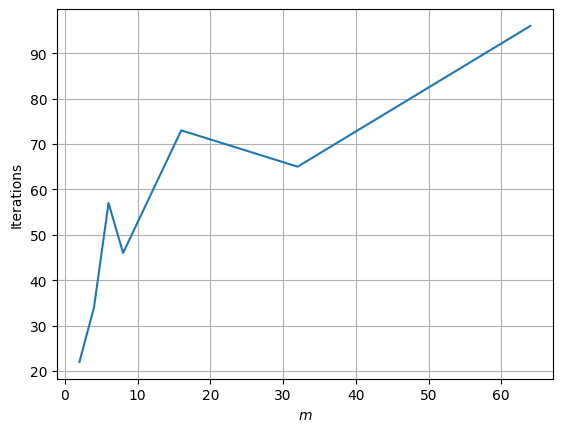

In [98]:
plt.plot(ms, iters)
plt.grid()
plt.xlabel("$m$")
plt.ylabel("Iterations")

Text(0.5, 0, 'Iterations')

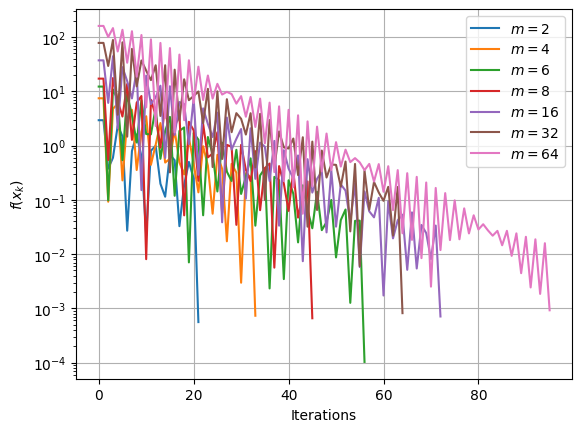

In [99]:
for m in ms:
    plt.plot(errs[m][1],label="$m="+str(m)+"$")
plt.yscale("log")
plt.legend()
plt.grid()
plt.ylabel("$f(x_k)$")
plt.xlabel("Iterations")

Text(0.5, 0, 'Iterations')

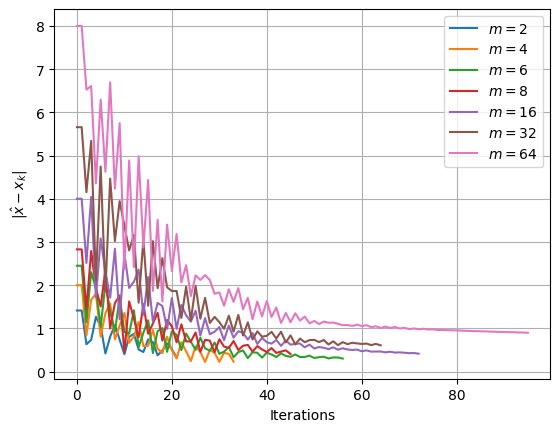

In [100]:
for m in ms:
    plt.plot(np.linalg.norm(errs[m][0]-np.ones((m,1)),axis=1),label="$m="+str(m)+"$")
# plt.yscale("log")
plt.legend()
plt.grid()
plt.ylabel("$|\hat{x}-x_k|$")
plt.xlabel("Iterations")

Заметим, что скорость сходимости увеличилась по сравнению с классическим градиентным спуском в около 4 раза